## Verify GPU

In [1]:
import tensorflow as tf

# Enable GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU setup successful") # I'm not sure if this is useful, sometimes it might be
    except RuntimeError as e:
        print(e)

# Verify GPU usage
print("TensorFlow version:", tf.__version__)
print("Is there a GPU:", tf.config.list_physical_devices('GPU'))
print("Current device:", tf.test.gpu_device_name())

GPU setup successful
TensorFlow version: 2.9.0
Is there a GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Current device: /device:GPU:0


## Reading Captchas with OCR Model

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Load the Dataset

In [ ]:
# Path to the data directory
data_dir = Path("./new/")

# Define vocabulary
characters = [chr(i) for i in range(65, 91)]  # A-Z
vocab = characters

# Get list of all the images
images = sorted(map(str, list(data_dir.glob("*.png"))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

# Captcha length is fixed at 6
captcha_length = 6

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(vocab))
print("Characters present: ", vocab)

# Other parameters remain unchanged
batch_size = 32
img_width = 280
img_height = 80
downsample_factor = 8

In [ ]:
# Verify label format when dataset is large to prevent training errors
def verify_labels():
    print("\nDetailed check...")
    
    # Check label length
    invalid_length = [label for label in labels if len(label) != 6]
    if invalid_length:
        print("\nLabels not of length 6:")
        for label in invalid_length[:5]:
            print(f"- {label} (length: {len(label)})")
    
    # Check character validity
    invalid_chars = []
    for label in labels:
        for char in label:
            if char not in vocab:
                invalid_chars.append((label, char))
    
    if invalid_chars:
        print("\nLabels containing invalid characters:")
        for label, char in invalid_chars[:5]:
            print(f"- {label} (invalid char: {char})")
    
    # Show some valid samples
    valid_samples = [label for label in labels if len(label) == 6 and all(char in vocab for char in label)]
    if valid_samples:
        print("\nValid sample examples:")
        for label in valid_samples[:5]:
            print(f"- {label}")
    
    # Summary
    print("\nCheck Summary:")
    print(f"Total labels: {len(labels)}")
    print(f"Incorrect length: {len(invalid_length)}")
    print(f"Contains invalid characters: {len(invalid_chars)}")
    valid_count = len([label for label in labels if len(label) == 6 and all(char in vocab for char in label)])
    print(f"Valid labels: {valid_count}")

# Run verification
verify_labels()

## Preprocessing the Dataset

In [9]:
# Mapping characters to integers (A-Z -> 0-25)
char_to_num = layers.StringLookup(
    vocabulary=vocab,
    mask_token=None,
    num_oov_indices=0,
    oov_token="[UNK]"
)

# Mapping integers back to characters (0-25 -> A-Z)
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(),
    invert=True,
    mask_token=None,
    num_oov_indices=0,
    oov_token="[UNK]"
)

In [10]:
def encode_single_sample(img_path, label):
    # Image processing part
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=4)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Alpha channel processing
    alpha = img[:, :, 3:] / 255.0
    white_background = tf.ones_like(img[:, :, :3])
    img_rgb = img[:, :, :3] / 255.0
    img = img_rgb * alpha + white_background * (1 - alpha)

    # Convert to grayscale and process
    img = tf.image.rgb_to_grayscale(img)
    # img = 1.0 - img
    img = tf.image.resize(img, [img_height, img_width])
    
    # Label processing - Process each character separately
    label_chars = tf.strings.unicode_split(label, input_encoding="UTF-8")
    
    # Create 6 independent one-hot encoded labels
    labels_onehot = []
    for i in range(6):
        char = label_chars[i]
        index = char_to_num(char)
        onehot = tf.one_hot(index, depth=len(vocab))
        labels_onehot.append(onehot)
    
    return {
        "image": img,
        "label_1": labels_onehot[0],
        "label_2": labels_onehot[1],
        "label_3": labels_onehot[2],
        "label_4": labels_onehot[3],
        "label_5": labels_onehot[4],
        "label_6": labels_onehot[5]
    }

## Create Dataset Objects

In [11]:
# Step 1: Split raw data into training and validation sets
# This function only splits the raw data (file paths and labels)
# It doesn't create TensorFlow datasets yet

def split_data(images, labels, train_size=0.9, shuffle=True):
    size = len(images)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    
    train_samples = int(size * train_size)
    
    # Convert to numpy arrays and split
    x_train = np.array(images)[indices[:train_samples]]
    x_valid = np.array(images)[indices[train_samples:]]
    
    # Label processing - each label has 6 letters
    y_train = np.array(labels)[indices[:train_samples]]
    y_valid = np.array(labels)[indices[train_samples:]]
    
    return x_train, x_valid, y_train, y_valid

# Split into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(images, labels)

In [ ]:
# Step 2: Create proper TensorFlow datasets with the split data
# This function transforms raw data into TensorFlow Dataset objects

def prepare_dataset(images, labels, batch_size):
    # Create initial dataset from raw data
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # Apply preprocessing to images and labels
    dataset = dataset.map(
        encode_single_sample,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    
    # Reorganize the data format for model training
    dataset = dataset.map(
        lambda x: (
            x["image"],
            {
                'char_1': x['label_1'],
                'char_2': x['label_2'],
                'char_3': x['label_3'],
                'char_4': x['label_4'],
                'char_5': x['label_5'],
                'char_6': x['label_6']
            }
        )
    )
    
    # Set batch size and enable prefetching for performance
    return dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
# Finally, create the actual training and validation datasets
train_dataset = prepare_dataset(x_train, y_train, batch_size)
validation_dataset = prepare_dataset(x_valid, y_valid, batch_size)

## Visualize the Data

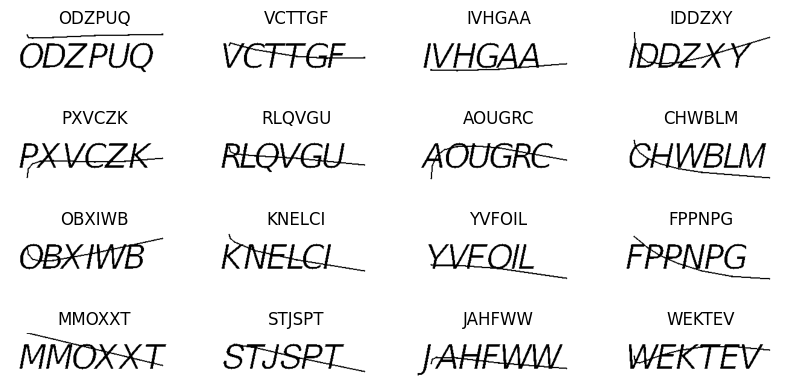

In [12]:
# Visualization code
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for images, labels in train_dataset.take(1):
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        
        # Get each character position
        char_1 = vocab[tf.argmax(labels['char_1'][i]).numpy()]
        char_2 = vocab[tf.argmax(labels['char_2'][i]).numpy()]
        char_3 = vocab[tf.argmax(labels['char_3'][i]).numpy()]
        char_4 = vocab[tf.argmax(labels['char_4'][i]).numpy()]
        char_5 = vocab[tf.argmax(labels['char_5'][i]).numpy()]
        char_6 = vocab[tf.argmax(labels['char_6'][i]).numpy()]
        
        # Combine into complete captcha text
        label_text = char_1 + char_2 + char_3 + char_4 + char_5 + char_6
        
        ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
        ax[i // 4, i % 4].set_title(label_text)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Create the OCR Model

In [13]:
def build_model():
    # Modify the input layer shape to (80, 280, 1) to match the processed image dimensions
    input_img = layers.Input(
        shape=(img_height, img_width, 1), name="image", dtype="float32"
    )

    # Initial normalization
    x = layers.BatchNormalization()(input_img)
    
    # Convolutional block 1
    x = layers.Conv2D(16, (3, 3), padding="same", name="Conv1", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = layers.Dropout(0.2)(x)
    
    # Convolutional block 2
    x = layers.Conv2D(32, (3, 3), padding="same", name="Conv2", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    x = layers.Dropout(0.2)(x)
    
    # Convolutional block 3
    x = layers.Conv2D(64, (3, 3), padding="same", name="Conv3", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D((2, 2), name="pool3")(x)
    x = layers.Dropout(0.2)(x)
    
    # Flatten features
    x = layers.Flatten()(x)
    
    # Fully connected layer
    x = layers.Dense(128, name="dense1", kernel_regularizer=keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.3)(x)
    
    # Output layer - 6 character positions, each with 26 possible characters
    outputs = []
    for i in range(6):
        output = layers.Dense(26, activation='softmax', name=f'char_{i+1}')(x)
        outputs.append(output)

    model = keras.models.Model(inputs=input_img, outputs=outputs)
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'char_1': 'categorical_crossentropy',
            'char_2': 'categorical_crossentropy',
            'char_3': 'categorical_crossentropy',
            'char_4': 'categorical_crossentropy',
            'char_5': 'categorical_crossentropy',
            'char_6': 'categorical_crossentropy'
        },
        metrics={
            'char_1': 'accuracy',
            'char_2': 'accuracy',
            'char_3': 'accuracy',
            'char_4': 'accuracy',
            'char_5': 'accuracy',
            'char_6': 'accuracy'
        }
    )
    
    return model

# Create model
model = build_model()

## Train the Neural Network

In [ ]:
# Define callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.25,
        patience=15,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        "checkpoint_model.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=False, # Ensure saving the complete model
        verbose=1
    )
]

# L2 regularization
regularizer = keras.regularizers.l2(1e-4)
for layer in model.layers:
    if isinstance(layer, layers.Dense) or isinstance(layer, layers.Conv2D):
        layer.kernel_regularizer = regularizer

# Train model
with tf.device('GPU:0'):
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=300,
        callbacks=callbacks
    )

# Save the complete model after training
tf.keras.models.save_model(
    model,
    'complete_model.h5',
    save_format='h5',
    include_optimizer=False # Do not save optimizer state to reduce file size
)

## Predictions with Trained Neural Network

1/1 [==============================] - 0s 158ms/step


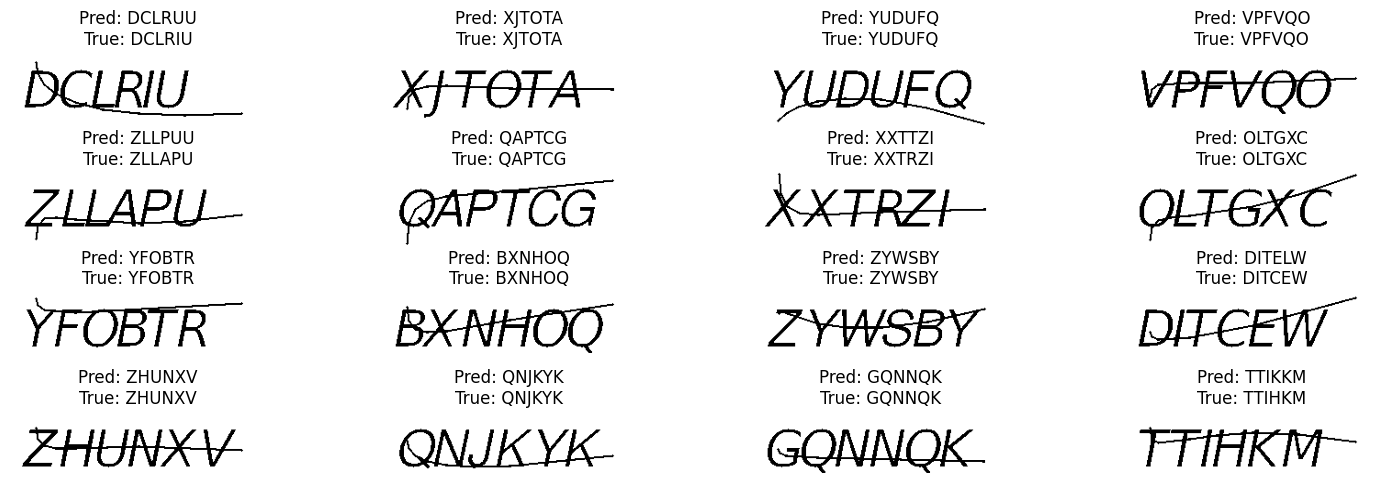

In [16]:
# Use the trained model for predictions
def decode_predictions(pred_dict):
    # The prediction result is a dictionary containing predictions for 6 character positions
    output_text = []
    
    # Iterate over each sample
    batch_size = pred_dict['char_1'].shape[0]
    for i in range(batch_size):
        # Get the predicted character for each position
        char_1 = vocab[np.argmax(pred_dict['char_1'][i])]
        char_2 = vocab[np.argmax(pred_dict['char_2'][i])]
        char_3 = vocab[np.argmax(pred_dict['char_3'][i])]
        char_4 = vocab[np.argmax(pred_dict['char_4'][i])]
        char_5 = vocab[np.argmax(pred_dict['char_5'][i])]
        char_6 = vocab[np.argmax(pred_dict['char_6'][i])]
        
        # Combine into complete captcha text
        text = char_1 + char_2 + char_3 + char_4 + char_5 + char_6
        output_text.append(text)
    
    return output_text

# Check results on the validation set
for images, labels in validation_dataset.take(1):
    # Make predictions
    predictions = model.predict(images)
    pred_dict = {
        'char_1': predictions[0],
        'char_2': predictions[1],
        'char_3': predictions[2],
        'char_4': predictions[3],
        'char_5': predictions[4],
        'char_6': predictions[5]
    }
    pred_texts = decode_predictions(pred_dict)
    
    # Get original labels
    true_texts = []
    for i in range(images.shape[0]):
        char_1 = vocab[tf.argmax(labels['char_1'][i]).numpy()]
        char_2 = vocab[tf.argmax(labels['char_2'][i]).numpy()]
        char_3 = vocab[tf.argmax(labels['char_3'][i]).numpy()]
        char_4 = vocab[tf.argmax(labels['char_4'][i]).numpy()]
        char_5 = vocab[tf.argmax(labels['char_5'][i]).numpy()]
        char_6 = vocab[tf.argmax(labels['char_6'][i]).numpy()]
        true_text = char_1 + char_2 + char_3 + char_4 + char_5 + char_6
        true_texts.append(true_text)
    
    # Visualize results
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(min(len(pred_texts), 16)):
        img = (images[i] * 255).numpy().astype(np.uint8)
        title = f"Pred: {pred_texts[i]}\nTrue: {true_texts[i]}"
        ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.tight_layout()
plt.show()